<a href="https://colab.research.google.com/github/ashioyajotham/Quant/blob/main/Food%20Delivery%20Cost%20and%20Profitability%20Analysis/Food_Delivery_Cost_and_Profitability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal is to identify areas where the service can reduce costs, increase revenue, and implement pricing or commission strategies that enhance profitability. So, in essence we want to learn how to perform cost and profitability analysis of a business operation, this article is for you.

We will examine all the costs associated with delivering food orders, from direct expenses like delivery fees and packaging to indirect expenses like discounts offered to customers and commission fees paid by restaurants. By juxtaposing these costs against the revenue generated (primarily through order values and commission fees), the analysis aims to provide insights into how profitable the food delivery service is on a per-order basis.

In [2]:
import pandas as pd

data = pd.read_csv('/content/food_orders_new_delhi.csv')
data.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


## EDA

In [7]:
# Check for missing data
missing_data = data.isnull().sum()

# Drop columns with more than 50% missing data
data = data.dropna(axis=1, thresh=0.5)

data.isnull().sum()

Order ID                  0
Customer ID               0
Restaurant ID             0
Order Date and Time       0
Delivery Date and Time    0
Order Value               0
Delivery Fee              0
Payment Method            0
Discounts and Offers      0
Commission Fee            0
Payment Processing Fee    0
Refunds/Chargebacks       0
dtype: int64

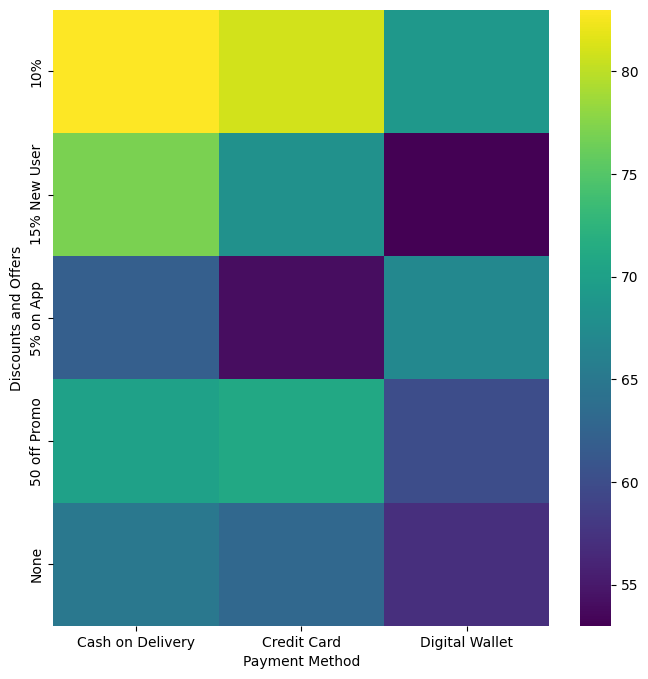

In [6]:
# @title Payment Method vs Discounts and Offers

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Discounts and Offers'].value_counts()
    for x_label, grp in data.groupby('Payment Method')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Payment Method')
_ = plt.ylabel('Discounts and Offers')

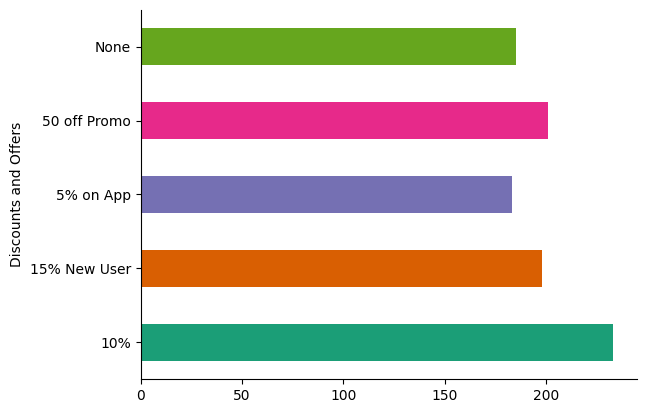

In [5]:
# @title Discounts and Offers

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Discounts and Offers').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

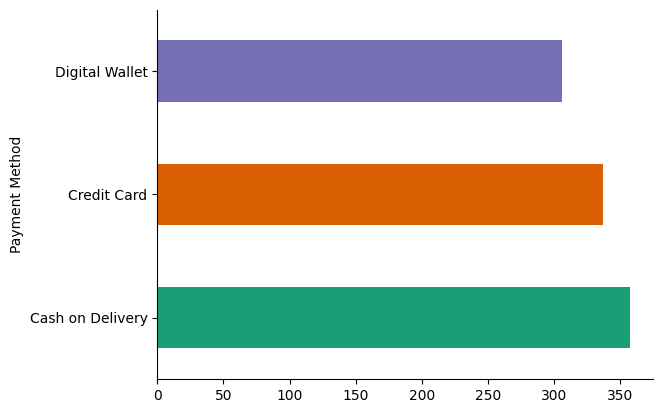

In [4]:
# @title Payment Method

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Payment Method').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

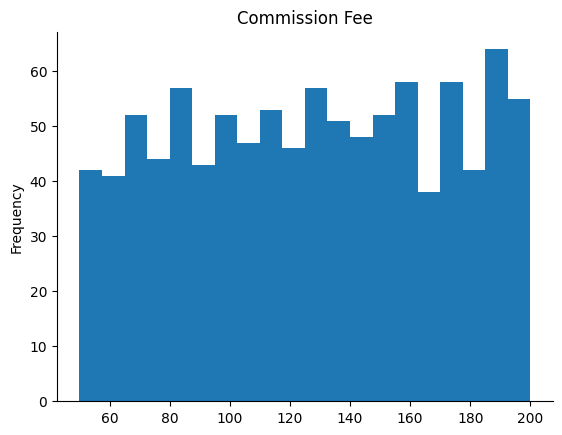

In [3]:
# @title Commission Fee

from matplotlib import pyplot as plt
data['Commission Fee'].plot(kind='hist', bins=20, title='Commission Fee')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    1000 non-null   object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


## Feature Engineering

In [9]:
from datetime import datetime

# convert date and time columns to datetime
data['Order Date and Time'] = pd.to_datetime(data['Order Date and Time'])
data['Delivery Date and Time'] = pd.to_datetime(data['Delivery Date and Time'])

# first, let's create a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

# apply the function to create a new 'Discount Value' column
data['Discount Percentage'] = data['Discounts and Offers'].apply(lambda x: extract_discount(x))

# for percentage discounts, calculate the discount amount based on the order value
data['Discount Amount'] = data.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
data['Discount Amount'] = data.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

print(data[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), data.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                 None                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

For the cost analysis, we’ll consider the following costs associated with each order:

* `Delivery Fee`: The fee charged for delivering the order.
Payment Processing Fee: The fee for processing the payment.
* `Discount Amount`: The discount provided on the order.
We’ll calculate the total cost for the platform per order and then aggregate this data to understand the overall cost structure.

The revenue for the platform is mainly derived from the Commission Fee. We’ll calculate the net profit by subtracting the total costs (including discounts) from the revenue generated through commission fees.

In [10]:
# calculate total costs and revenue per order
data['Total Costs'] = data['Delivery Fee'] + data['Payment Processing Fee'] + data['Discount Amount']
data['Revenue'] = data['Commission Fee']
data['Profit'] = data['Revenue'] - data['Total Costs']

# aggregate data to get overall metrics
total_orders = data.shape[0]
total_revenue = data['Revenue'].sum()
total_costs = data['Total Costs'].sum()
total_profit = data['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 232709.85, 'Total Profit': -105719.85}


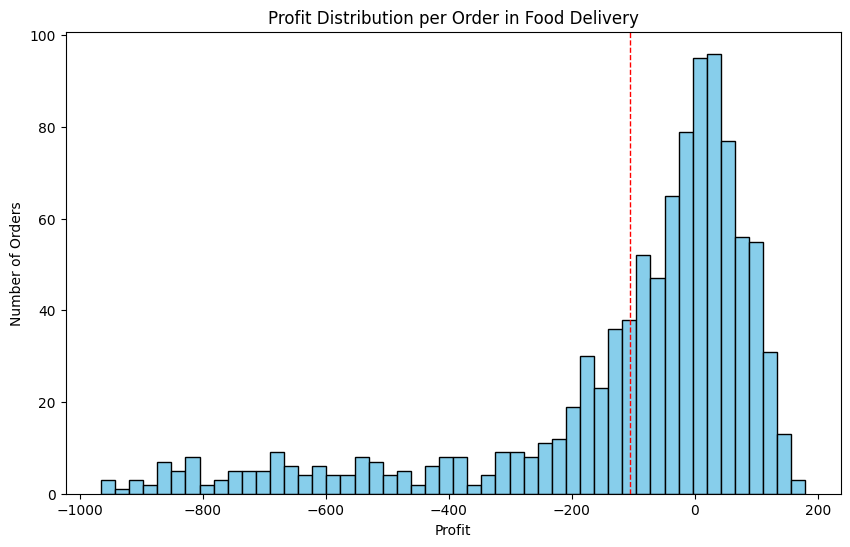

In [15]:
# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(data['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(data['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

In [14]:
data.columns

Index(['Order ID', 'Customer ID', 'Restaurant ID', 'Order Date and Time',
       'Delivery Date and Time', 'Order Value', 'Delivery Fee',
       'Payment Method', 'Discounts and Offers', 'Commission Fee',
       'Payment Processing Fee', 'Refunds/Chargebacks', 'Discount Percentage',
       'Discount Amount', 'Total Costs', 'Revenue', 'Profit'],
      dtype='object')

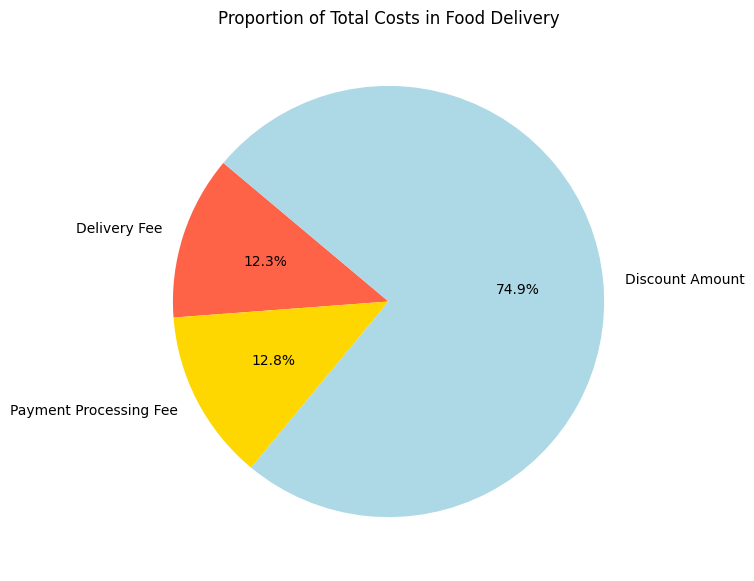

In [16]:
# pie chart for the proportion of total costs
costs_breakdown = data[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

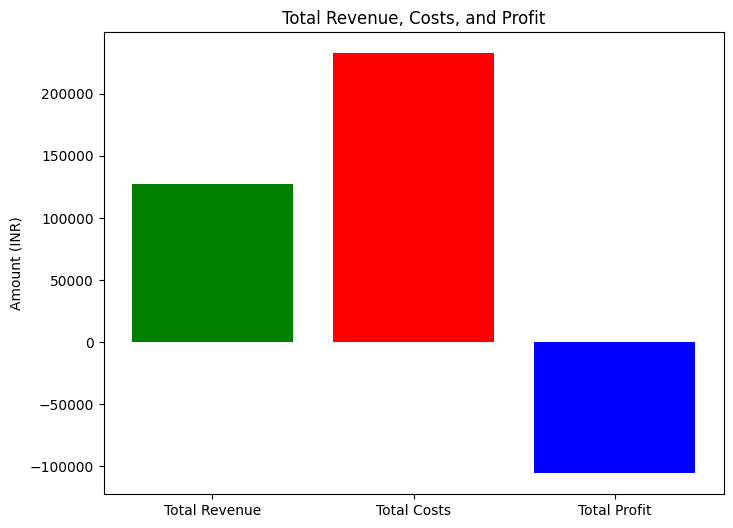

In [17]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show();

# A new strategy for profits
From the analysis so far we understood that the discounts on food orders are resulting in huge losses. Now, we need to find a new strategy for profitability. We need to find a sweet spot for offering discounts and charging commissions. To find a sweet spot for commission and discount percentages, we can analyze the characteristics of profitable orders more deeply. Specifically, we need to look for:

* A new average commission percentage based on profitable orders.
* A new average discount percentage for profitable orders, that could serve as a guideline for what level of discount still allows for profitability.

Given these new averages, we can suggest adjustments that might not only make individual orders profitable but also apply broadly across all orders to improve overall profitability. Let’s calculate:

* The average commission percentage for profitable orders.
* The average discount percentage for profitable orders.

In [18]:
# filter the dataset for profitable orders
profitable_orders = data[data['Profit'] > 0]

# calculate the average commission percentage for profitable orders
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# calculate the average discount percentage for profitable orders
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)

30.508436145149435 5.867469879518072


<ipython-input-18-086d9e31cb72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100
<ipython-input-18-086d9e31cb72>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100


Based on the analysis of profitable orders, we find a new set of averages that could represent a “sweet spot” for commission and discount percentages:

* New Average Commission Percentage: 30.51%
* New Average Discount Percentage: 5.87%

The average commission percentage for profitable orders is significantly higher than the overall average across all orders. It suggests that a higher commission rate on orders might be a key factor in achieving profitability. The average discount percentage for profitable orders is notably lower than the overall average, indicating that lower discounts might contribute to profitability without significantly deterring order volume.

Based on this analysis, a strategy that aims for a commission rate closer to 30% and a discount rate around 6% could potentially improve profitability across the board.

Now, let’s visualize a comparison of profitability using actual versus recommended discounts and commissions across all orders. For this, we need to calculate the profitability per order using the actual discounts and commissions already present in the dataset.
Simulate profitability per order using the recommended discounts (6%) and commissions (30%) to see the potential impact on profitability.
This comparison will help illustrate the potential impact of adopting the recommended discount and commission rates on the overall profitability of orders. Here’s how to visualize this comparison:

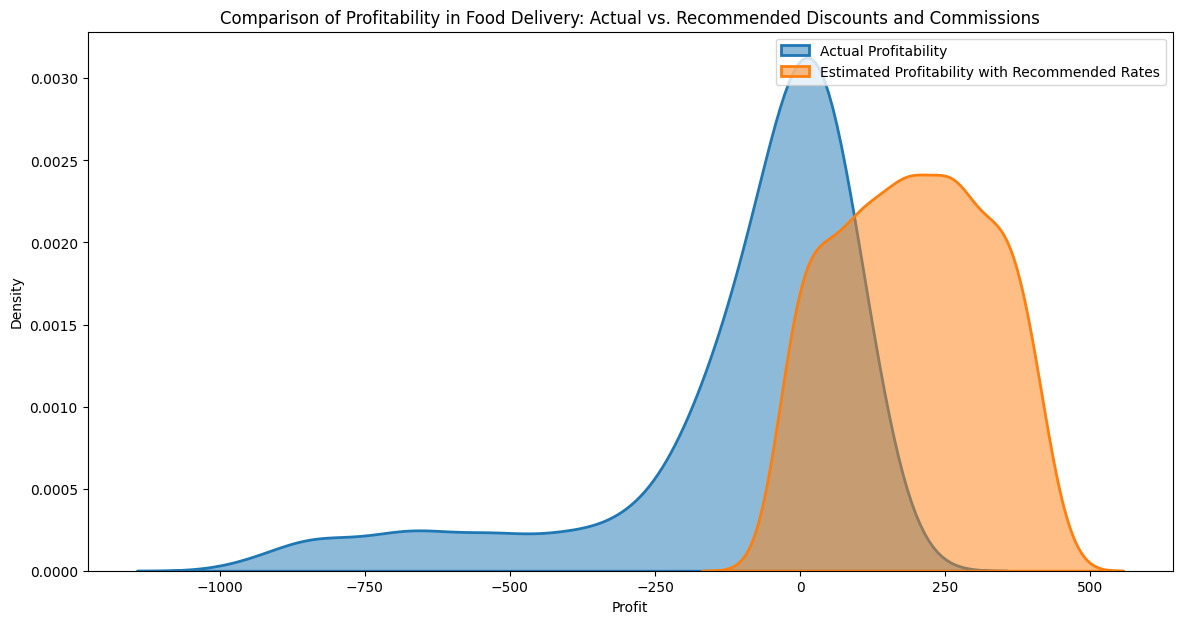

In [20]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = 30.0  # 30%
recommended_discount_percentage = 6.0    # 6%

# calculate the simulated commission fee and discount amount using recommended percentages
data['Simulated Commission Fee'] = data['Order Value'] * (recommended_commission_percentage / 100)
data['Simulated Discount Amount'] = data['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
data['Simulated Total Costs'] = (data['Delivery Fee'] +
                                        data['Payment Processing Fee'] +
                                        data['Simulated Discount Amount'])

data['Simulated Profit'] = (data['Simulated Commission Fee'] -
                                   data['Simulated Total Costs'])

# visualizing the comparison
import seaborn as sns

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(data['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(data['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend()
plt.show();

The visualization compares the distribution of profitability per order using actual discounts and commissions versus the simulated scenario with recommended discounts (6%) and commissions (30%).

The actual profitability distribution shows a mix, with a significant portion of orders resulting in losses (profit < 0) and a broad spread of profit levels for orders. The simulated scenario suggests a shift towards higher profitability per order. The distribution is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.


#### Acknowledgements
[Huge shoutout to Aman Kharwal for the script. Really helped a lot!](https://thecleverprogrammer.com/2024/02/12/food-delivery-cost-and-profitability-analysis-using-python/)